In [1]:
#pip install -r requirements.txt

import pandas as pd
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt

import seaborn as sns

import scipy.stats as stats
from scipy.stats import norm

from sklearn.metrics import mean_absolute_error, mean_squared_error
import statsmodels.api as sm
from IPython.display import display, HTML

In [2]:
##################################__DATA LOAD__################################################

In [3]:
interest_rate = pd.read_csv('./data/interest_rate.csv')
energy_price = pd.read_csv('./data/energy_price.csv')
cpi = pd.read_csv('./data/cpi.csv')
inflation = pd.read_csv('./data/inflation.csv')

In [4]:
##################################__DATA SANITY CHECKS__################################################

In [5]:
interest_rate.head(1000)

,location,interest_rate_long_term,year,month,interest_rate_short_term,interest_rate_immediate_term
0,AUS,7.177895,2000,1,5.66,5.00
1,AUS,6.957619,2000,2,5.80,5.48
2,AUS,6.570435,2000,3,5.89,5.50
3,AUS,6.264706,2000,4,6.04,5.72
4,AUS,6.465652,2000,5,6.31,5.98
...,...,...,...,...,...,...
995,USA,2.530000,2014,9,0.12,0.09
996,USA,2.300000,2014,10,0.12,0.09
997,USA,2.330000,2014,11,0.13,0.09
998,USA,2.210000,2014,12,0.15,0.12


In [6]:
cpi.head(2000)

,location,cpi-index,year,month
0,AUS,3.700000,1948,9
1,AUS,3.733333,1948,10
2,AUS,3.766667,1948,11
3,AUS,3.800000,1948,12
4,AUS,3.833333,1949,1
...,...,...,...,...
1575,EU,117.010000,2022,6
1576,EU,117.140000,2022,7
1577,EU,117.850000,2022,8
1578,EU,119.260000,2022,9


In [7]:
energy_price.head(1000)

,energy_price,year,month,energy_price_lag_3m,energy_price_lag_6m,energy_price_lag_9m,energy_price_lag_12m,energy_price_lag_18m,energy_price_lag_24m,energy_price_lag_30m,energy_price_lag_36m,energy_price_lag_40m,energy_price_lag_46m,location
0,55.275,2006,11,68.240,64.980,56.225,50.565,47.250,38.645,36.400,28.515,27.380,30.430,AUS
1,58.015,2006,12,58.850,64.715,57.690,52.850,51.795,35.540,34.405,29.640,28.800,31.845,AUS
2,50.870,2007,1,55.020,68.460,65.020,58.580,53.130,41.080,36.325,30.370,26.360,29.800,AUS
3,53.995,2007,2,55.275,68.240,64.980,56.225,58.100,41.640,40.060,29.730,28.160,25.380,AUS
4,58.055,2007,3,58.015,58.850,64.715,57.690,57.710,49.330,39.310,32.300,28.515,26.170,AUS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
850,18.965,1993,3,18.045,16.520,13.910,13.555,16.275,16.980,16.435,18.750,19.610,23.455,EU
851,18.410,1993,2,18.700,16.900,15.190,14.015,17.505,17.075,16.135,17.440,18.360,23.325,EU
852,17.755,1993,1,18.960,16.705,16.640,13.890,17.845,16.565,15.905,17.620,18.230,23.050,EU
853,18.290,1992,12,18.965,18.045,16.520,13.910,16.740,16.380,17.215,17.795,20.690,23.840,EU


In [8]:
#merge all separate data into one dataframe

df = interest_rate.merge(cpi, on=['location', 'year', 'month'], suffixes=('', '_delme'))
df = df.merge(energy_price, on=['location', 'year', 'month'], suffixes=('', '_delme'))
df = df.merge(inflation, on=['location', 'year', 'month'], suffixes=('', '_delme'))
df = df[[c for c in df.columns if not c.endswith('_delme')]]

In [9]:
df.head(1000)

,location,interest_rate_long_term,year,month,interest_rate_short_term,interest_rate_immediate_term,cpi-index,energy_price,energy_price_lag_3m,energy_price_lag_6m,...,energy_price_lag_12m,energy_price_lag_18m,energy_price_lag_24m,energy_price_lag_30m,energy_price_lag_36m,energy_price_lag_40m,energy_price_lag_46m,inflation,inflation_lag_9m,inflation_lag_12m
0,AUS,5.599545,2006,11,6.37,6.19,86.633333,55.275,68.240,64.980,...,50.565,47.250,38.645,36.400,28.515,27.380,30.430,3.533333,2.866667,2.900000
1,AUS,5.696579,2006,12,6.39,6.25,86.600000,58.015,58.850,64.715,...,52.850,51.795,35.540,34.405,29.640,28.800,31.845,3.300000,2.900000,2.800000
2,AUS,5.877619,2007,1,6.43,6.25,86.600000,50.870,55.020,68.460,...,58.580,53.130,41.080,36.325,30.370,26.360,29.800,3.033333,3.266667,2.833333
3,AUS,5.809250,2007,2,6.37,6.25,86.600000,53.995,55.275,68.240,...,56.225,58.100,41.640,40.060,29.730,28.160,25.380,2.766667,3.633333,2.866667
4,AUS,5.736818,2007,3,6.43,6.25,86.600000,58.055,58.015,58.850,...,57.690,57.710,49.330,39.310,32.300,28.515,26.170,2.500000,4.000000,2.900000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
687,USA,2.900000,2022,5,1.33,0.77,292.296000,109.550,91.640,79.150,...,65.170,40.940,28.560,57.030,60.830,51.380,70.980,8.600000,5.300000,5.000000
688,USA,3.140000,2022,6,1.87,1.21,296.311000,114.840,108.500,71.710,...,71.380,47.020,38.310,59.880,54.660,54.950,68.060,9.100000,5.400000,5.400000
689,USA,2.900000,2022,7,2.50,1.68,296.276000,101.620,101.780,83.220,...,72.490,52.000,40.710,57.520,57.350,58.150,70.230,8.500000,6.200000,5.400000
690,USA,2.900000,2022,8,2.76,2.33,296.171000,93.670,109.550,91.640,...,67.730,59.040,42.340,50.540,54.810,63.860,70.750,8.300000,6.800000,5.300000


In [10]:
#Columns present in the dataset
df.columns

Index(['location', 'interest_rate_long_term', 'year', 'month',
       'interest_rate_short_term', 'interest_rate_immediate_term', 'cpi-index',
       'energy_price', 'energy_price_lag_3m', 'energy_price_lag_6m',
       'energy_price_lag_9m', 'energy_price_lag_12m', 'energy_price_lag_18m',
       'energy_price_lag_24m', 'energy_price_lag_30m', 'energy_price_lag_36m',
       'energy_price_lag_40m', 'energy_price_lag_46m', 'inflation',
       'inflation_lag_9m', 'inflation_lag_12m'],
      dtype='object')

In [11]:
#Checking for null values
df.isnull().sum()

location                        0
interest_rate_long_term         0
year                            0
month                           0
interest_rate_short_term        0
interest_rate_immediate_term    0
cpi-index                       0
energy_price                    0
energy_price_lag_3m             0
energy_price_lag_6m             0
energy_price_lag_9m             0
energy_price_lag_12m            0
energy_price_lag_18m            0
energy_price_lag_24m            0
energy_price_lag_30m            0
energy_price_lag_36m            0
energy_price_lag_40m            0
energy_price_lag_46m            0
inflation                       0
inflation_lag_9m                0
inflation_lag_12m               0
dtype: int64

In [12]:
#Checking datatypes of columns
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 692 entries, 0 to 691
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   location                      692 non-null    object 
 1   interest_rate_long_term       692 non-null    float64
 2   year                          692 non-null    int64  
 3   month                         692 non-null    int64  
 4   interest_rate_short_term      692 non-null    float64
 5   interest_rate_immediate_term  692 non-null    float64
 6   cpi-index                     692 non-null    float64
 7   energy_price                  692 non-null    float64
 8   energy_price_lag_3m           692 non-null    float64
 9   energy_price_lag_6m           692 non-null    float64
 10  energy_price_lag_9m           692 non-null    float64
 11  energy_price_lag_12m          692 non-null    float64
 12  energy_price_lag_18m          692 non-null    float64
 13  energ

In [13]:
#Stats of data
df.describe()

,interest_rate_long_term,year,month,interest_rate_short_term,interest_rate_immediate_term,cpi-index,energy_price,energy_price_lag_3m,energy_price_lag_6m,energy_price_lag_9m,energy_price_lag_12m,energy_price_lag_18m,energy_price_lag_24m,energy_price_lag_30m,energy_price_lag_36m,energy_price_lag_40m,energy_price_lag_46m,inflation,inflation_lag_9m,inflation_lag_12m
count,692.000000,692.000000,692.000000,692.000000,692.000000,692.000000,692.000000,692.000000,692.000000,692.000000,692.000000,692.000000,692.000000,692.000000,692.000000,692.000000,692.000000,692.000000,692.00000,692.000000
mean,3.374245,2011.200867,6.471098,2.434355,2.221911,146.531106,66.799191,66.439668,66.035390,65.667500,65.411655,64.888772,64.707312,65.015694,64.965499,65.042074,65.048591,2.215366,2.09894,2.073410
std,1.448119,6.087528,3.453730,2.112878,2.075118,64.446095,28.003371,27.928703,27.647075,27.575497,27.680998,28.000968,28.167271,28.012448,28.210596,28.579080,29.025065,1.404845,1.15804,1.117555
min,0.620000,2000.000000,1.000000,0.010000,0.050000,74.860000,17.730000,16.550000,16.550000,16.550000,12.010000,11.280000,11.280000,11.280000,11.280000,11.280000,11.280000,-2.100000,-2.10000,-2.100000
25%,2.167025,2007.000000,3.000000,0.556377,0.423175,94.825000,45.242500,45.187500,45.187500,45.187500,45.187500,44.715000,44.603750,44.911250,44.687500,44.305000,43.207500,1.500000,1.50000,1.500000
50%,3.350000,2011.000000,6.000000,1.820000,1.500000,109.000000,63.675000,63.425000,63.295000,62.942500,62.532500,61.672500,61.167500,62.230000,62.347500,62.532500,62.657500,2.100000,2.10000,2.066667
75%,4.615625,2016.000000,9.000000,4.224183,4.100575,211.280500,89.457500,88.346250,86.387500,85.141250,85.141250,85.141250,85.141250,85.141250,85.141250,86.350000,88.346250,2.775000,2.70000,2.700000
max,6.660000,2022.000000,12.000000,7.900000,7.250000,296.808000,134.190000,134.190000,134.190000,134.190000,134.190000,134.190000,134.190000,134.190000,134.190000,134.190000,134.190000,9.100000,7.00000,5.600000


In [14]:
df.head(1000)

,location,interest_rate_long_term,year,month,interest_rate_short_term,interest_rate_immediate_term,cpi-index,energy_price,energy_price_lag_3m,energy_price_lag_6m,...,energy_price_lag_12m,energy_price_lag_18m,energy_price_lag_24m,energy_price_lag_30m,energy_price_lag_36m,energy_price_lag_40m,energy_price_lag_46m,inflation,inflation_lag_9m,inflation_lag_12m
0,AUS,5.599545,2006,11,6.37,6.19,86.633333,55.275,68.240,64.980,...,50.565,47.250,38.645,36.400,28.515,27.380,30.430,3.533333,2.866667,2.900000
1,AUS,5.696579,2006,12,6.39,6.25,86.600000,58.015,58.850,64.715,...,52.850,51.795,35.540,34.405,29.640,28.800,31.845,3.300000,2.900000,2.800000
2,AUS,5.877619,2007,1,6.43,6.25,86.600000,50.870,55.020,68.460,...,58.580,53.130,41.080,36.325,30.370,26.360,29.800,3.033333,3.266667,2.833333
3,AUS,5.809250,2007,2,6.37,6.25,86.600000,53.995,55.275,68.240,...,56.225,58.100,41.640,40.060,29.730,28.160,25.380,2.766667,3.633333,2.866667
4,AUS,5.736818,2007,3,6.43,6.25,86.600000,58.055,58.015,58.850,...,57.690,57.710,49.330,39.310,32.300,28.515,26.170,2.500000,4.000000,2.900000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
687,USA,2.900000,2022,5,1.33,0.77,292.296000,109.550,91.640,79.150,...,65.170,40.940,28.560,57.030,60.830,51.380,70.980,8.600000,5.300000,5.000000
688,USA,3.140000,2022,6,1.87,1.21,296.311000,114.840,108.500,71.710,...,71.380,47.020,38.310,59.880,54.660,54.950,68.060,9.100000,5.400000,5.400000
689,USA,2.900000,2022,7,2.50,1.68,296.276000,101.620,101.780,83.220,...,72.490,52.000,40.710,57.520,57.350,58.150,70.230,8.500000,6.200000,5.400000
690,USA,2.900000,2022,8,2.76,2.33,296.171000,93.670,109.550,91.640,...,67.730,59.040,42.340,50.540,54.810,63.860,70.750,8.300000,6.800000,5.300000


In [15]:
##################################__Data Prep__################################################

In [16]:
df_au = df[df['location'] == 'AUS']
df_us = df[df['location'] == 'USA']
df_eu = df[df['location'] == 'EU']

In [17]:
##################################__Linear Regression__################################################




================================COUNTRY AUS====================================
============================cpi-index vs energy_price==========================
                            OLS Regression Results                            
Dep. Variable:           energy_price   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     6.835
Date:                Tue, 08 Nov 2022   Prob (F-statistic):            0.00966
Time:                        09:43:23   Log-Likelihood:                -888.11
No. Observations:                 191   AIC:                             1780.
Df Residuals:                     189   BIC:                             1787.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t    

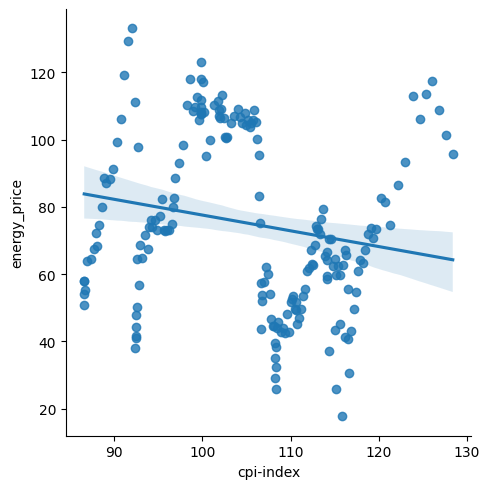




================================COUNTRY USA====================================
============================cpi-index vs energy_price==========================
                            OLS Regression Results                            
Dep. Variable:           energy_price   R-squared:                       0.209
Model:                            OLS   Adj. R-squared:                  0.206
Method:                 Least Squares   F-statistic:                     71.23
Date:                Tue, 08 Nov 2022   Prob (F-statistic):           1.96e-15
Time:                        09:43:23   Log-Likelihood:                -1240.0
No. Observations:                 272   AIC:                             2484.
Df Residuals:                     270   BIC:                             2491.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t    

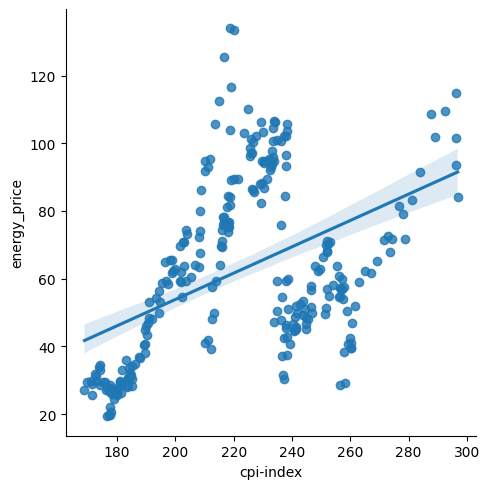




================================COUNTRY EU====================================
============================cpi-index vs energy_price==========================
                            OLS Regression Results                            
Dep. Variable:           energy_price   R-squared:                       0.382
Model:                            OLS   Adj. R-squared:                  0.379
Method:                 Least Squares   F-statistic:                     140.0
Date:                Tue, 08 Nov 2022   Prob (F-statistic):           1.76e-25
Time:                        09:43:23   Log-Likelihood:                -1052.4
No. Observations:                 229   AIC:                             2109.
Df Residuals:                     227   BIC:                             2116.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t     

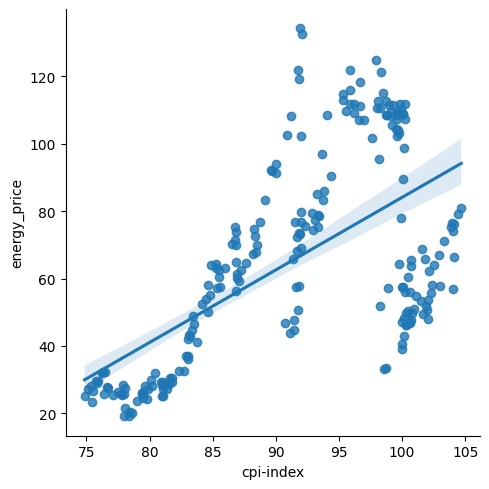




================================COUNTRY AUS====================================
============================cpi-index vs interest_rate_immediate_term==========================
                                 OLS Regression Results                                 
Dep. Variable:     interest_rate_immediate_term   R-squared:                       0.830
Model:                                      OLS   Adj. R-squared:                  0.829
Method:                           Least Squares   F-statistic:                     921.5
Date:                          Tue, 08 Nov 2022   Prob (F-statistic):           1.34e-74
Time:                                  09:43:23   Log-Likelihood:                -233.45
No. Observations:                           191   AIC:                             470.9
Df Residuals:                               189   BIC:                             477.4
Df Model:                                     1                                         
Covariance Type:    

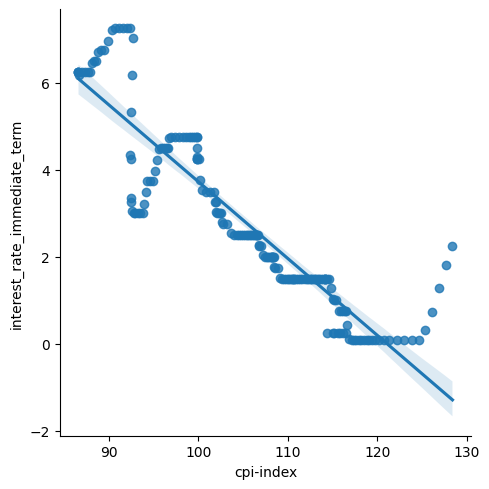




================================COUNTRY USA====================================
============================cpi-index vs interest_rate_immediate_term==========================
                                 OLS Regression Results                                 
Dep. Variable:     interest_rate_immediate_term   R-squared:                       0.282
Model:                                      OLS   Adj. R-squared:                  0.279
Method:                           Least Squares   F-statistic:                     106.1
Date:                          Tue, 08 Nov 2022   Prob (F-statistic):           3.40e-21
Time:                                  09:43:23   Log-Likelihood:                -510.10
No. Observations:                           272   AIC:                             1024.
Df Residuals:                               270   BIC:                             1031.
Df Model:                                     1                                         
Covariance Type:    

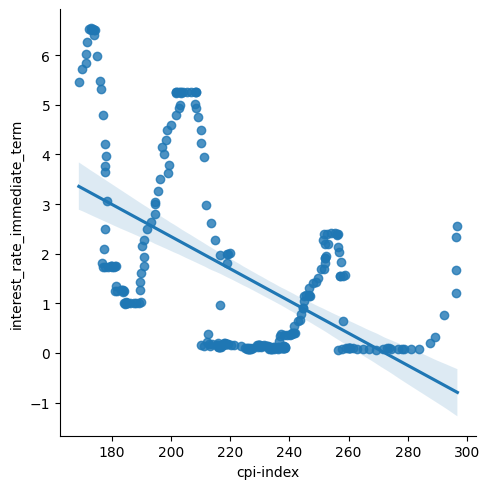




================================COUNTRY EU====================================
============================cpi-index vs interest_rate_immediate_term==========================
                                 OLS Regression Results                                 
Dep. Variable:     interest_rate_immediate_term   R-squared:                       0.722
Model:                                      OLS   Adj. R-squared:                  0.721
Method:                           Least Squares   F-statistic:                     589.1
Date:                          Tue, 08 Nov 2022   Prob (F-statistic):           5.25e-65
Time:                                  09:43:24   Log-Likelihood:                -358.64
No. Observations:                           229   AIC:                             721.3
Df Residuals:                               227   BIC:                             728.1
Df Model:                                     1                                         
Covariance Type:     

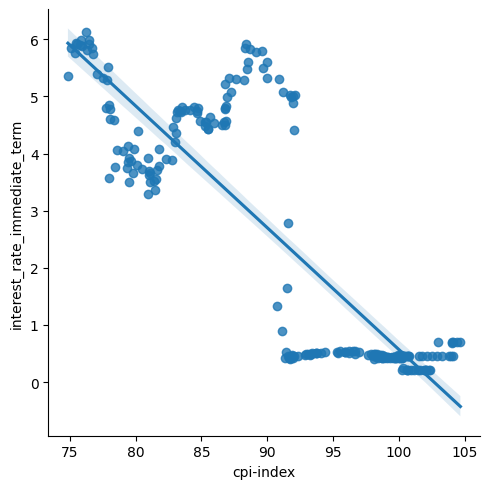




================================COUNTRY AUS====================================
============================cpi-index vs inflation==========================
                            OLS Regression Results                            
Dep. Variable:              inflation   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.4972
Date:                Tue, 08 Nov 2022   Prob (F-statistic):              0.482
Time:                        09:43:24   Log-Likelihood:                -305.07
No. Observations:                 191   AIC:                             614.1
Df Residuals:                     189   BIC:                             620.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P

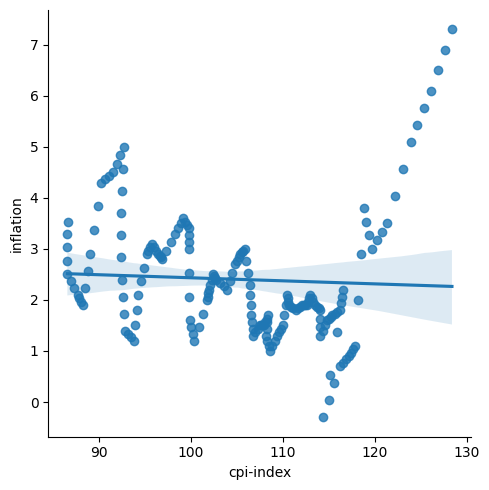




================================COUNTRY USA====================================
============================cpi-index vs inflation==========================
                            OLS Regression Results                            
Dep. Variable:              inflation   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     10.12
Date:                Tue, 08 Nov 2022   Prob (F-statistic):            0.00164
Time:                        09:43:24   Log-Likelihood:                -530.99
No. Observations:                 272   AIC:                             1066.
Df Residuals:                     270   BIC:                             1073.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P

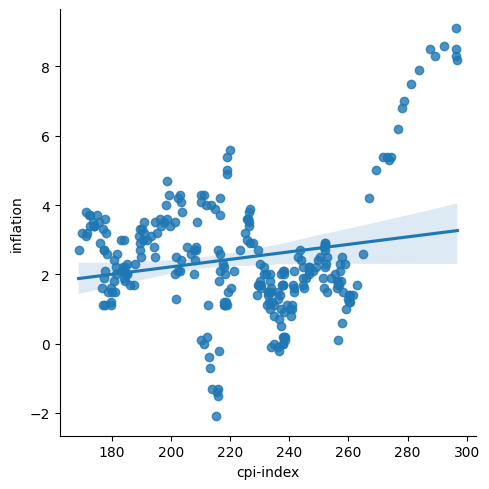




================================COUNTRY EU====================================
============================cpi-index vs inflation==========================
                            OLS Regression Results                            
Dep. Variable:              inflation   R-squared:                       0.198
Model:                            OLS   Adj. R-squared:                  0.194
Method:                 Least Squares   F-statistic:                     55.98
Date:                Tue, 08 Nov 2022   Prob (F-statistic):           1.60e-12
Time:                        09:43:24   Log-Likelihood:                -286.40
No. Observations:                 229   AIC:                             576.8
Df Residuals:                     227   BIC:                             583.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>

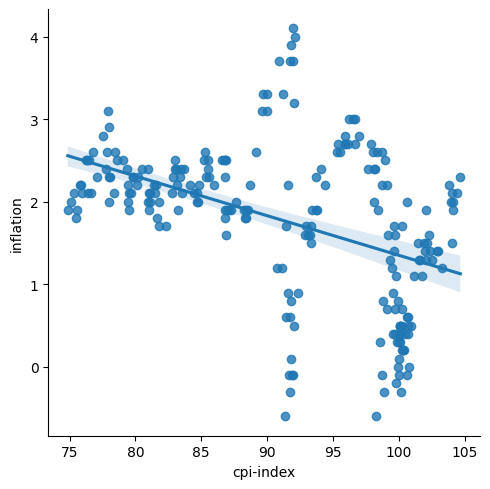




================================COUNTRY AUS====================================
============================inflation vs interest_rate_immediate_term==========================
                                 OLS Regression Results                                 
Dep. Variable:     interest_rate_immediate_term   R-squared:                       0.113
Model:                                      OLS   Adj. R-squared:                  0.109
Method:                           Least Squares   F-statistic:                     24.14
Date:                          Tue, 08 Nov 2022   Prob (F-statistic):           1.93e-06
Time:                                  09:43:24   Log-Likelihood:                -391.08
No. Observations:                           191   AIC:                             786.2
Df Residuals:                               189   BIC:                             792.7
Df Model:                                     1                                         
Covariance Type:    

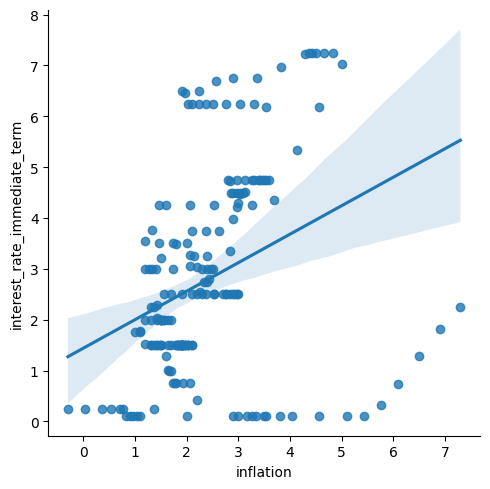




================================COUNTRY USA====================================
============================inflation vs interest_rate_immediate_term==========================
                                 OLS Regression Results                                 
Dep. Variable:     interest_rate_immediate_term   R-squared:                       0.078
Model:                                      OLS   Adj. R-squared:                  0.075
Method:                           Least Squares   F-statistic:                     22.89
Date:                          Tue, 08 Nov 2022   Prob (F-statistic):           2.83e-06
Time:                                  09:43:24   Log-Likelihood:                -544.09
No. Observations:                           272   AIC:                             1092.
Df Residuals:                               270   BIC:                             1099.
Df Model:                                     1                                         
Covariance Type:    

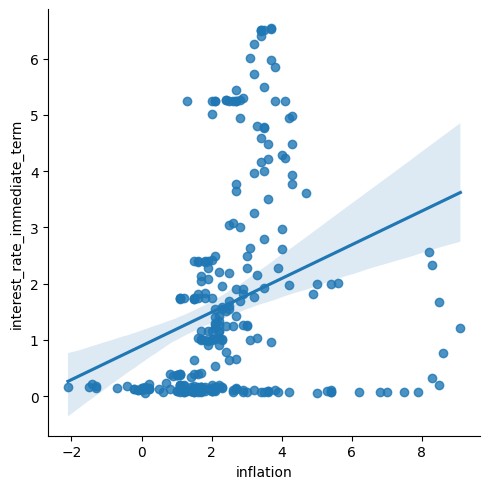




================================COUNTRY EU====================================
============================inflation vs interest_rate_immediate_term==========================
                                 OLS Regression Results                                 
Dep. Variable:     interest_rate_immediate_term   R-squared:                       0.333
Model:                                      OLS   Adj. R-squared:                  0.330
Method:                           Least Squares   F-statistic:                     113.1
Date:                          Tue, 08 Nov 2022   Prob (F-statistic):           1.08e-21
Time:                                  09:43:25   Log-Likelihood:                -458.87
No. Observations:                           229   AIC:                             921.7
Df Residuals:                               227   BIC:                             928.6
Df Model:                                     1                                         
Covariance Type:     

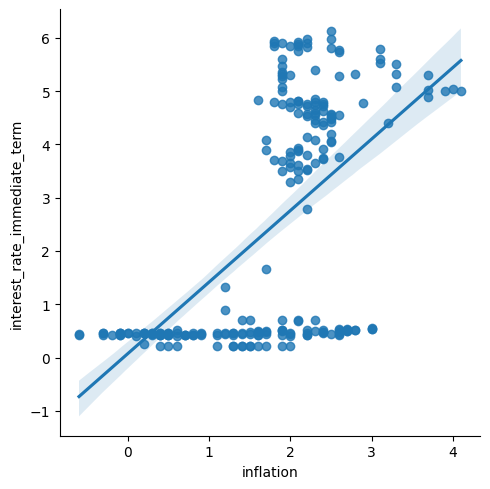




================================COUNTRY AUS====================================
============================inflation vs interest_rate_short_term==========================
                               OLS Regression Results                               
Dep. Variable:     interest_rate_short_term   R-squared:                       0.127
Model:                                  OLS   Adj. R-squared:                  0.122
Method:                       Least Squares   F-statistic:                     27.37
Date:                      Tue, 08 Nov 2022   Prob (F-statistic):           4.44e-07
Time:                              09:43:25   Log-Likelihood:                -395.71
No. Observations:                       191   AIC:                             795.4
Df Residuals:                           189   BIC:                             801.9
Df Model:                                 1                                         
Covariance Type:                  nonrobust                 

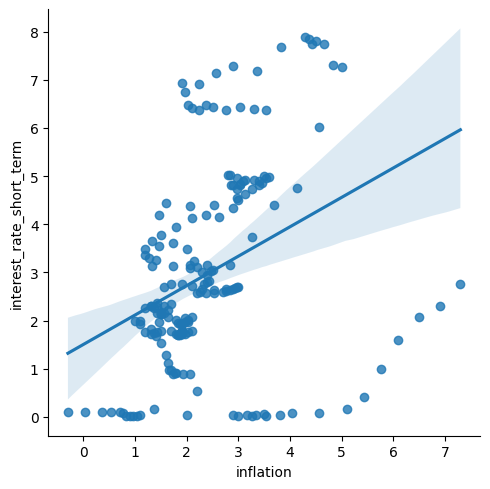




================================COUNTRY USA====================================
============================inflation vs interest_rate_short_term==========================
                               OLS Regression Results                               
Dep. Variable:     interest_rate_short_term   R-squared:                       0.095
Model:                                  OLS   Adj. R-squared:                  0.091
Method:                       Least Squares   F-statistic:                     28.21
Date:                      Tue, 08 Nov 2022   Prob (F-statistic):           2.27e-07
Time:                              09:43:25   Log-Likelihood:                -544.11
No. Observations:                       272   AIC:                             1092.
Df Residuals:                           270   BIC:                             1099.
Df Model:                                 1                                         
Covariance Type:                  nonrobust                 

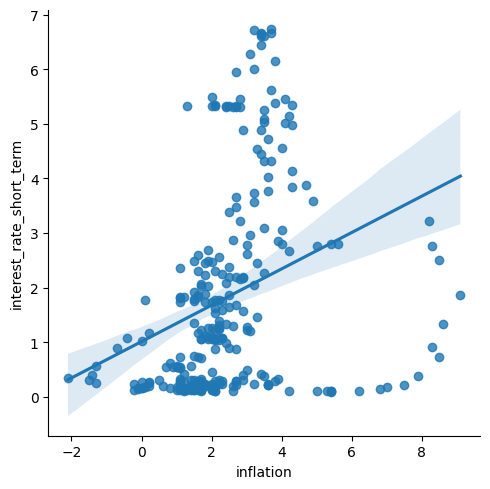




================================COUNTRY EU====================================
============================inflation vs interest_rate_short_term==========================
                               OLS Regression Results                               
Dep. Variable:     interest_rate_short_term   R-squared:                       0.351
Model:                                  OLS   Adj. R-squared:                  0.349
Method:                       Least Squares   F-statistic:                     123.0
Date:                      Tue, 08 Nov 2022   Prob (F-statistic):           4.03e-23
Time:                              09:43:25   Log-Likelihood:                -459.56
No. Observations:                       229   AIC:                             923.1
Df Residuals:                           227   BIC:                             930.0
Df Model:                                 1                                         
Covariance Type:                  nonrobust                  

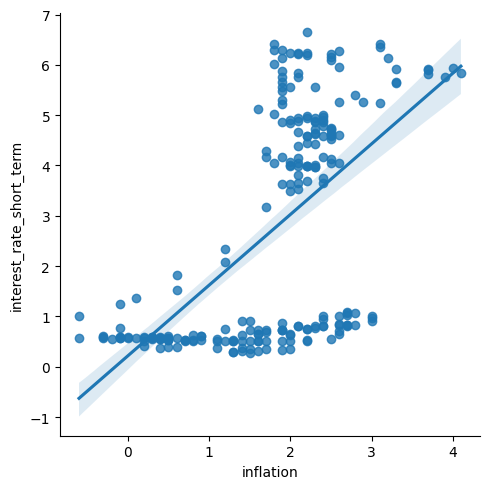




================================COUNTRY AUS====================================
============================inflation vs interest_rate_long_term==========================
                               OLS Regression Results                              
Dep. Variable:     interest_rate_long_term   R-squared:                       0.186
Model:                                 OLS   Adj. R-squared:                  0.181
Method:                      Least Squares   F-statistic:                     43.05
Date:                     Tue, 08 Nov 2022   Prob (F-statistic):           4.98e-10
Time:                             09:43:25   Log-Likelihood:                -341.59
No. Observations:                      191   AIC:                             687.2
Df Residuals:                          189   BIC:                             693.7
Df Model:                                1                                         
Covariance Type:                 nonrobust                            

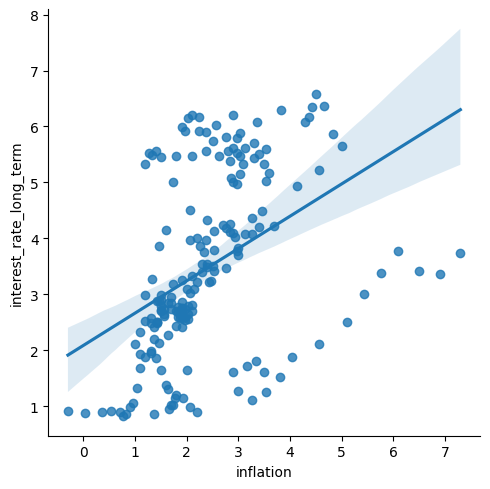




================================COUNTRY USA====================================
============================inflation vs interest_rate_long_term==========================
                               OLS Regression Results                              
Dep. Variable:     interest_rate_long_term   R-squared:                       0.031
Model:                                 OLS   Adj. R-squared:                  0.027
Method:                      Least Squares   F-statistic:                     8.642
Date:                     Tue, 08 Nov 2022   Prob (F-statistic):            0.00357
Time:                             09:43:25   Log-Likelihood:                -458.85
No. Observations:                      272   AIC:                             921.7
Df Residuals:                          270   BIC:                             928.9
Df Model:                                1                                         
Covariance Type:                 nonrobust                            

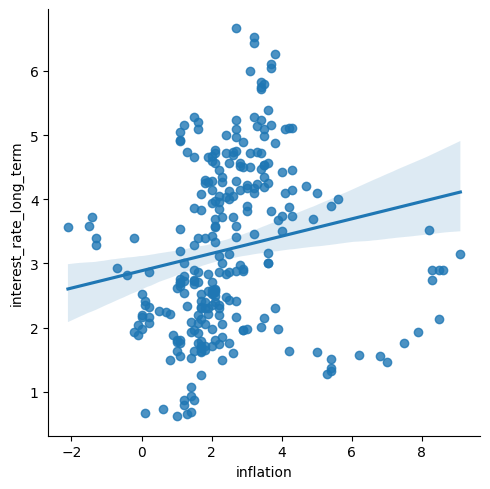




================================COUNTRY EU====================================
============================inflation vs interest_rate_long_term==========================
                               OLS Regression Results                              
Dep. Variable:     interest_rate_long_term   R-squared:                       0.255
Model:                                 OLS   Adj. R-squared:                  0.251
Method:                      Least Squares   F-statistic:                     77.55
Date:                     Tue, 08 Nov 2022   Prob (F-statistic):           3.38e-16
Time:                             09:43:26   Log-Likelihood:                -372.92
No. Observations:                      229   AIC:                             749.8
Df Residuals:                          227   BIC:                             756.7
Df Model:                                1                                         
Covariance Type:                 nonrobust                             

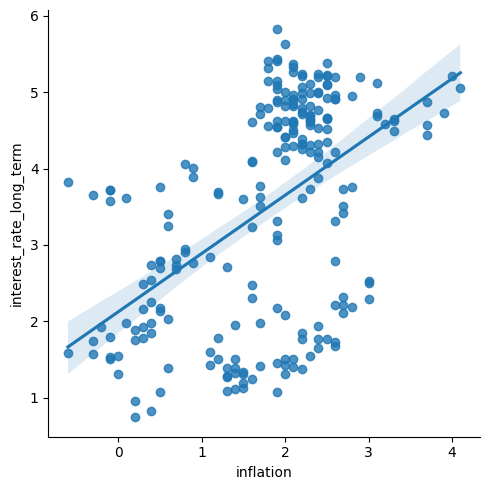




================================COUNTRY AUS====================================
============================inflation vs energy_price==========================
                            OLS Regression Results                            
Dep. Variable:           energy_price   R-squared:                       0.312
Model:                            OLS   Adj. R-squared:                  0.309
Method:                 Least Squares   F-statistic:                     85.90
Date:                Tue, 08 Nov 2022   Prob (F-statistic):           4.31e-17
Time:                        09:43:26   Log-Likelihood:                -855.73
No. Observations:                 191   AIC:                             1715.
Df Residuals:                     189   BIC:                             1722.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t    

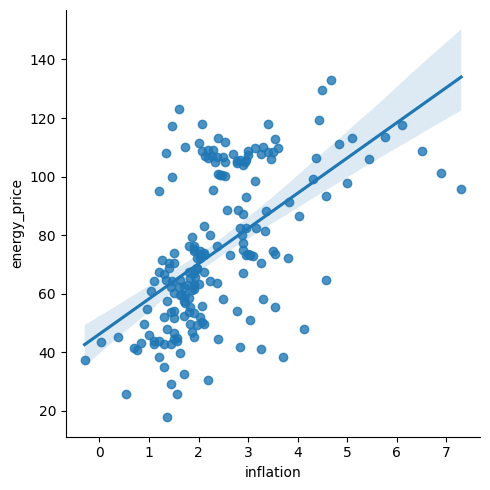




================================COUNTRY USA====================================
============================inflation vs energy_price==========================
                            OLS Regression Results                            
Dep. Variable:           energy_price   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     31.55
Date:                Tue, 08 Nov 2022   Prob (F-statistic):           4.84e-08
Time:                        09:43:26   Log-Likelihood:                -1256.8
No. Observations:                 272   AIC:                             2518.
Df Residuals:                     270   BIC:                             2525.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t    

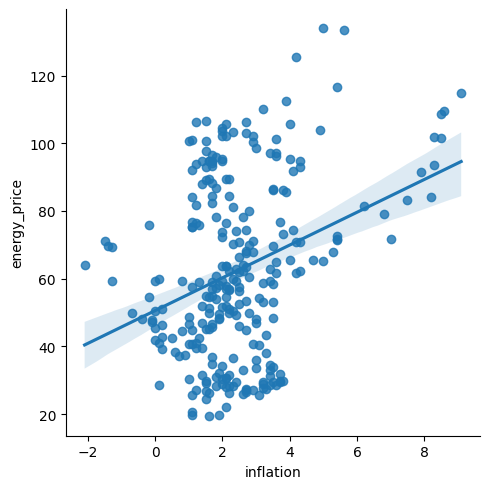




================================COUNTRY EU====================================
============================inflation vs energy_price==========================
                            OLS Regression Results                            
Dep. Variable:           energy_price   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     3.129
Date:                Tue, 08 Nov 2022   Prob (F-statistic):             0.0783
Time:                        09:43:26   Log-Likelihood:                -1105.9
No. Observations:                 229   AIC:                             2216.
Df Residuals:                     227   BIC:                             2223.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t     

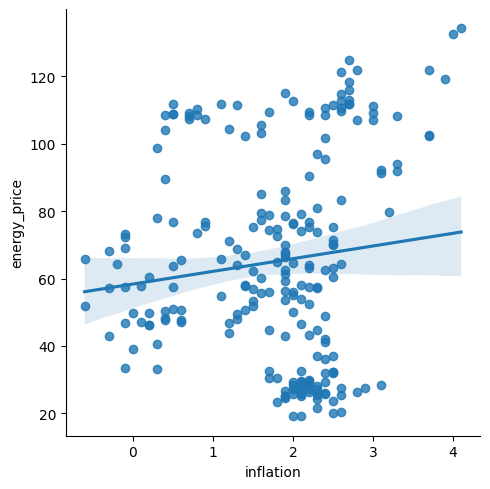




================================COUNTRY AUS====================================
============================interest_rate_immediate_term vs inflation_lag_9m==========================
                            OLS Regression Results                            
Dep. Variable:       inflation_lag_9m   R-squared:                       0.252
Model:                            OLS   Adj. R-squared:                  0.248
Method:                 Least Squares   F-statistic:                     63.81
Date:                Tue, 08 Nov 2022   Prob (F-statistic):           1.31e-13
Time:                        09:43:26   Log-Likelihood:                -235.75
No. Observations:                 191   AIC:                             475.5
Df Residuals:                     189   BIC:                             482.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        

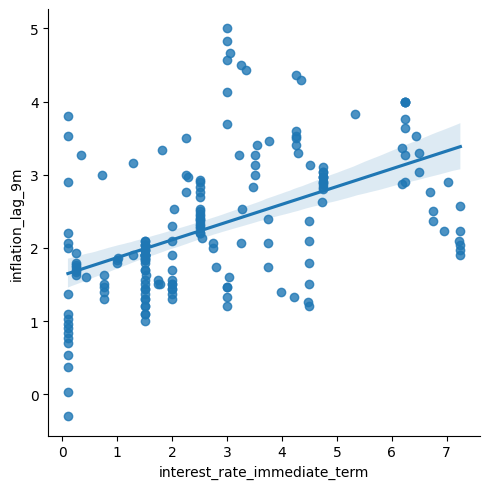




================================COUNTRY USA====================================
============================interest_rate_immediate_term vs inflation_lag_9m==========================
                            OLS Regression Results                            
Dep. Variable:       inflation_lag_9m   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     42.56
Date:                Tue, 08 Nov 2022   Prob (F-statistic):           3.37e-10
Time:                        09:43:26   Log-Likelihood:                -449.38
No. Observations:                 272   AIC:                             902.8
Df Residuals:                     270   BIC:                             910.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        

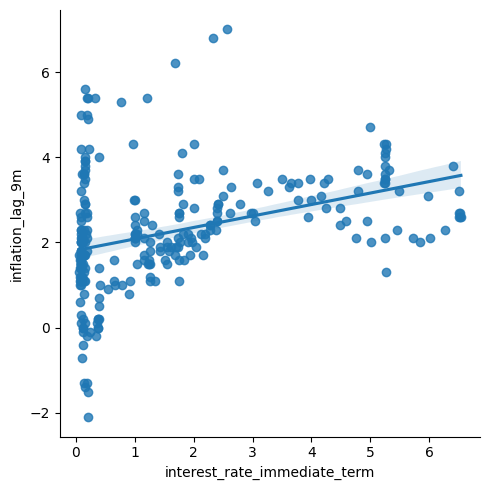




================================COUNTRY EU====================================
============================interest_rate_immediate_term vs inflation_lag_9m==========================
                            OLS Regression Results                            
Dep. Variable:       inflation_lag_9m   R-squared:                       0.142
Model:                            OLS   Adj. R-squared:                  0.138
Method:                 Least Squares   F-statistic:                     37.59
Date:                Tue, 08 Nov 2022   Prob (F-statistic):           3.83e-09
Time:                        09:43:27   Log-Likelihood:                -295.15
No. Observations:                 229   AIC:                             594.3
Df Residuals:                     227   BIC:                             601.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         

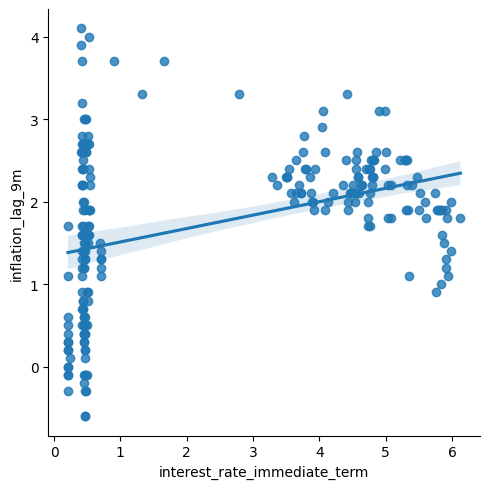

In [18]:
lr_features = [('cpi-index','energy_price'), ('cpi-index','interest_rate_immediate_term'), ('cpi-index','inflation'),
               ('inflation','interest_rate_immediate_term'),('inflation','interest_rate_short_term'),('inflation','interest_rate_long_term'),
               ('inflation','energy_price'),
              ('interest_rate_immediate_term','inflation_lag_9m')]
   
def linear_regresion_plot(df_feature,feature_x,feature_y,country_name):
    regr = linear_model.LinearRegression()
    x = df_feature[[feature_x]]
    y = df_feature[[feature_y]]
    regr.fit(x,y)  
    print()
    print()
    print()
    print(f'===============================================================================')
    print(f'================================COUNTRY {country_name}====================================')    
    print(f'============================{feature_x} vs {feature_y}==========================') 
    print(f'===============================================================================')
    print(sm.OLS(y, sm.add_constant(x)).fit().summary())
    
    sns.lmplot(x=feature_x, y=feature_y, data=df_feature)
    plt.show()
    
for feature_x, feature_y in lr_features:  
    linear_regresion_plot(df_au,feature_x,feature_y,'AUS')
    linear_regresion_plot(df_us,feature_x,feature_y,'USA')
    linear_regresion_plot(df_eu,feature_x,feature_y,'EU')

In [19]:
##################################__CORELATION__################################################

In [20]:
method='pearson'
min_periods=1




================================CORRELATION====================================
================================COUNTRY [AUD]===================================


,interest_rate_long_term,year,month,interest_rate_short_term,interest_rate_immediate_term,cpi-index,energy_price,energy_price_lag_3m,energy_price_lag_6m,energy_price_lag_9m,energy_price_lag_12m,energy_price_lag_18m,energy_price_lag_24m,energy_price_lag_30m,energy_price_lag_36m,energy_price_lag_40m,energy_price_lag_46m,inflation,inflation_lag_9m,inflation_lag_12m
interest_rate_long_term,1.000000,-0.893142,-0.018887,0.918390,0.906177,-0.864275,0.433379,0.364216,0.276800,0.217091,0.176123,0.112591,-0.000787,-0.065477,-0.132520,-0.195801,-0.280300,0.430721,0.553687,0.583901
year,-0.893142,1.000000,-0.061607,-0.908960,-0.924737,0.990732,-0.257264,-0.278091,-0.310770,-0.319875,-0.309895,-0.261300,-0.155160,-0.005700,0.110577,0.172841,0.265909,-0.127529,-0.554735,-0.603791
month,-0.018887,-0.061607,1.000000,0.005216,0.006214,0.004489,-0.009415,0.074984,-0.003646,-0.072921,0.001904,-0.006992,0.011913,0.001409,0.001306,0.074392,-0.069255,-0.016192,-0.002674,0.001447
interest_rate_short_term,0.918390,-0.908960,0.005216,1.000000,0.994767,-0.892233,0.387149,0.375855,0.311388,0.225446,0.144265,0.054731,-0.026459,-0.139848,-0.212513,-0.254866,-0.303659,0.355669,0.487430,0.516620
interest_rate_immediate_term,0.906177,-0.924737,0.006214,0.994767,1.000000,-0.910939,0.380136,0.383215,0.340641,0.261337,0.178498,0.074338,-0.009744,-0.129060,-0.211444,-0.260872,-0.323665,0.336563,0.502386,0.515050
cpi-index,-0.864275,0.990732,0.004489,-0.892233,-0.910939,1.000000,-0.186825,-0.193744,-0.242369,-0.267618,-0.260232,-0.226187,-0.131186,0.029349,0.157865,0.224091,0.300426,-0.051223,-0.521057,-0.578491
energy_price,0.433379,-0.257264,-0.009415,0.387149,0.380136,-0.186825,1.000000,0.826849,0.636333,0.503969,0.397423,0.202067,0.043259,-0.009244,-0.032449,-0.069452,-0.107391,0.559001,0.235901,0.234593
energy_price_lag_3m,0.364216,-0.278091,0.074984,0.375855,0.383215,-0.193744,0.826849,1.000000,0.824555,0.634053,0.506528,0.308012,0.159782,0.033988,0.010124,-0.022048,-0.065673,0.572632,0.274811,0.216586
energy_price_lag_6m,0.276800,-0.310770,-0.003646,0.311388,0.340641,-0.242369,0.636333,0.824555,1.000000,0.822879,0.640615,0.417738,0.253682,0.122793,0.031465,0.019521,-0.039796,0.399431,0.375413,0.252257
energy_price_lag_9m,0.217091,-0.319875,-0.072921,0.225446,0.261337,-0.267618,0.503969,0.634053,0.822879,1.000000,0.828715,0.526943,0.355096,0.235561,0.080575,0.047790,0.003008,0.174793,0.484658,0.357889


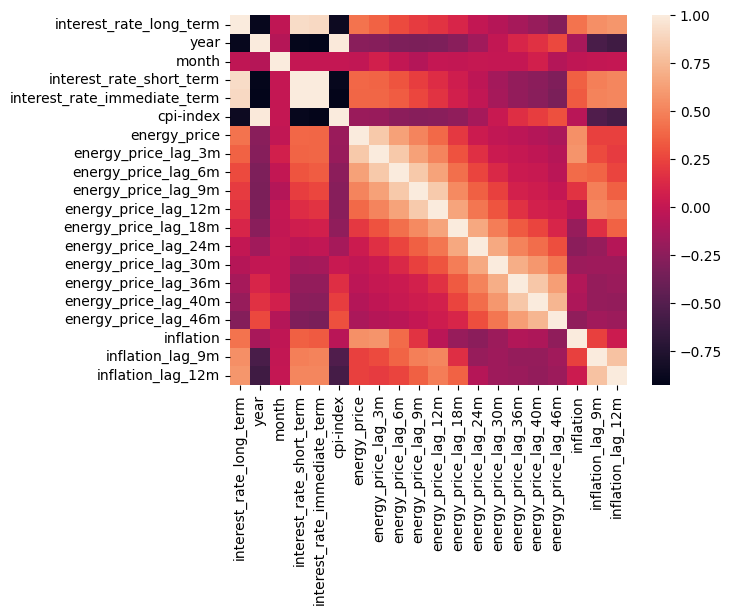




================================CORRELATION====================================
================================COUNTRY [USA]===================================


,interest_rate_long_term,year,month,interest_rate_short_term,interest_rate_immediate_term,cpi-index,energy_price,energy_price_lag_3m,energy_price_lag_6m,energy_price_lag_9m,energy_price_lag_12m,energy_price_lag_18m,energy_price_lag_24m,energy_price_lag_30m,energy_price_lag_36m,energy_price_lag_40m,energy_price_lag_46m,inflation,inflation_lag_9m,inflation_lag_12m
interest_rate_long_term,1.000000,-0.863408,-0.053153,0.767289,0.769266,-0.827503,-0.302359,-0.331695,-0.396765,-0.435461,-0.465585,-0.513580,-0.612359,-0.648222,-0.654243,-0.664749,-0.661073,0.176106,0.280751,0.334923
year,-0.863408,1.000000,-0.020812,-0.544418,-0.555717,0.986641,0.368775,0.358856,0.358299,0.363941,0.375191,0.412659,0.470353,0.549094,0.594155,0.614609,0.652349,0.075023,-0.164077,-0.234523
month,-0.053153,-0.020812,1.000000,-0.001169,-0.017956,0.019271,0.003808,0.077666,0.012243,-0.034567,0.025989,0.012472,0.028255,0.008884,0.016231,0.054732,-0.035669,-0.016066,-0.009423,0.005277
interest_rate_short_term,0.767289,-0.544418,-0.001169,1.000000,0.984704,-0.511400,-0.250018,-0.242372,-0.293715,-0.350707,-0.405256,-0.508984,-0.586084,-0.627649,-0.631988,-0.620259,-0.577090,0.307591,0.415540,0.388010
interest_rate_immediate_term,0.769266,-0.555717,-0.017956,0.984704,1.000000,-0.531066,-0.287792,-0.307738,-0.358605,-0.399426,-0.439402,-0.518589,-0.594653,-0.644175,-0.646214,-0.636708,-0.592611,0.279531,0.368991,0.360052
cpi-index,-0.827503,0.986641,0.019271,-0.511400,-0.531066,1.000000,0.456888,0.440227,0.413588,0.401111,0.401994,0.410461,0.453691,0.528094,0.576524,0.594539,0.625900,0.190049,-0.077020,-0.164475
energy_price,-0.302359,0.368775,0.003808,-0.250018,-0.287792,0.456888,1.000000,0.889826,0.761171,0.682517,0.624995,0.537058,0.490696,0.487908,0.462718,0.441168,0.410197,0.323444,0.076015,0.021740
energy_price_lag_3m,-0.331695,0.358856,0.077666,-0.242372,-0.307738,0.440227,0.889826,1.000000,0.888772,0.762451,0.685794,0.583523,0.535097,0.508815,0.498788,0.465422,0.445627,0.232237,0.107794,0.044124
energy_price_lag_6m,-0.396765,0.358299,0.012243,-0.293715,-0.358605,0.413588,0.761171,0.888772,1.000000,0.890191,0.772187,0.646497,0.579930,0.551786,0.523198,0.510505,0.471113,0.037222,0.141950,0.051817
energy_price_lag_9m,-0.435461,0.363941,-0.034567,-0.350707,-0.399426,0.401111,0.682517,0.762451,0.890191,1.000000,0.896078,0.710806,0.629088,0.600026,0.552085,0.534365,0.496381,-0.156816,0.206689,0.107041


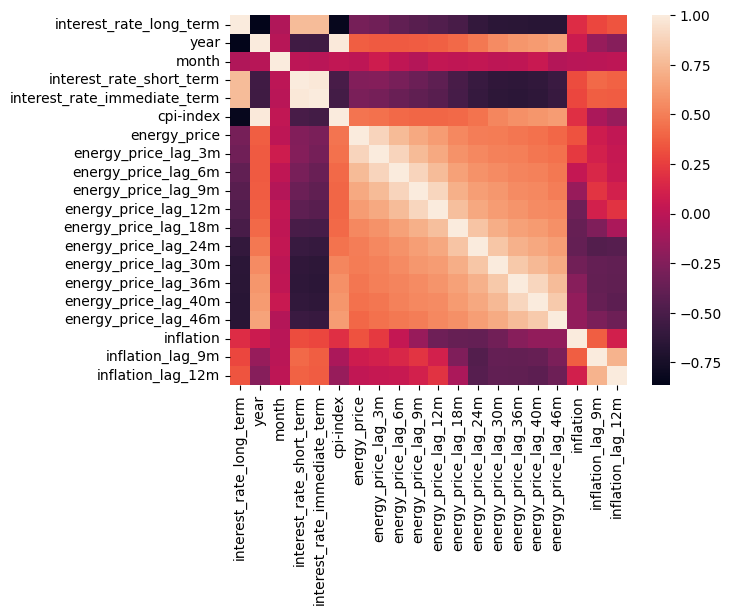




================================CORRELATION====================================
================================COUNTRY [EU]===================================


,interest_rate_long_term,year,month,interest_rate_short_term,interest_rate_immediate_term,cpi-index,energy_price,energy_price_lag_3m,energy_price_lag_6m,energy_price_lag_9m,energy_price_lag_12m,energy_price_lag_18m,energy_price_lag_24m,energy_price_lag_30m,energy_price_lag_36m,energy_price_lag_40m,energy_price_lag_46m,inflation,inflation_lag_9m,inflation_lag_12m
interest_rate_long_term,1.000000,-0.927532,-0.040886,0.874510,0.865985,-0.904854,-0.354122,-0.349739,-0.341123,-0.304918,-0.276337,-0.221857,-0.127317,-0.010047,0.113405,0.156741,0.207904,0.504622,0.432148,0.423219
year,-0.927532,1.000000,-0.012542,-0.837426,-0.843935,0.986430,0.507870,0.489059,0.461532,0.431084,0.408360,0.306471,0.205909,0.137006,0.080000,0.077131,0.040954,-0.495222,-0.468281,-0.435038
month,-0.040886,-0.012542,1.000000,-0.015474,-0.014243,0.053390,0.021881,-0.040109,0.014274,0.077990,0.017115,0.002654,0.021767,0.015928,0.024808,-0.009165,0.099108,0.018126,0.004810,0.018551
interest_rate_short_term,0.874510,-0.837426,-0.015474,1.000000,0.991239,-0.835902,-0.408674,-0.412537,-0.410386,-0.396967,-0.393608,-0.351013,-0.276955,-0.160094,-0.040075,0.031104,0.116177,0.592798,0.422217,0.339193
interest_rate_immediate_term,0.865985,-0.843935,-0.014243,0.991239,1.000000,-0.849614,-0.440336,-0.440243,-0.437518,-0.429040,-0.425341,-0.386237,-0.326231,-0.217481,-0.094668,-0.022679,0.067780,0.576642,0.376920,0.307087
cpi-index,-0.904854,0.986430,0.053390,-0.835902,-0.849614,1.000000,0.617662,0.584866,0.551096,0.518409,0.489692,0.378554,0.272460,0.192220,0.127323,0.108310,0.064789,-0.444769,-0.396943,-0.360002
energy_price,-0.354122,0.507870,0.021881,-0.408674,-0.440336,0.617662,1.000000,0.921056,0.825544,0.760632,0.708598,0.592831,0.467211,0.368003,0.294370,0.221756,0.125927,0.116604,0.063247,0.087456
energy_price_lag_3m,-0.349739,0.489059,-0.040109,-0.412537,-0.440243,0.584866,0.921056,1.000000,0.919127,0.821546,0.755604,0.635087,0.523760,0.389083,0.322862,0.253902,0.153301,0.078000,0.073256,0.094120
energy_price_lag_6m,-0.341123,0.461532,0.014274,-0.410386,-0.437518,0.551096,0.825544,0.919127,1.000000,0.917223,0.817811,0.683588,0.565646,0.437575,0.333177,0.284964,0.172993,0.044989,0.080001,0.095376
energy_price_lag_9m,-0.304918,0.431084,0.077990,-0.396967,-0.429040,0.518409,0.760632,0.821546,0.917223,1.000000,0.915644,0.736583,0.613170,0.497909,0.354761,0.297086,0.205395,0.038401,0.083603,0.088190


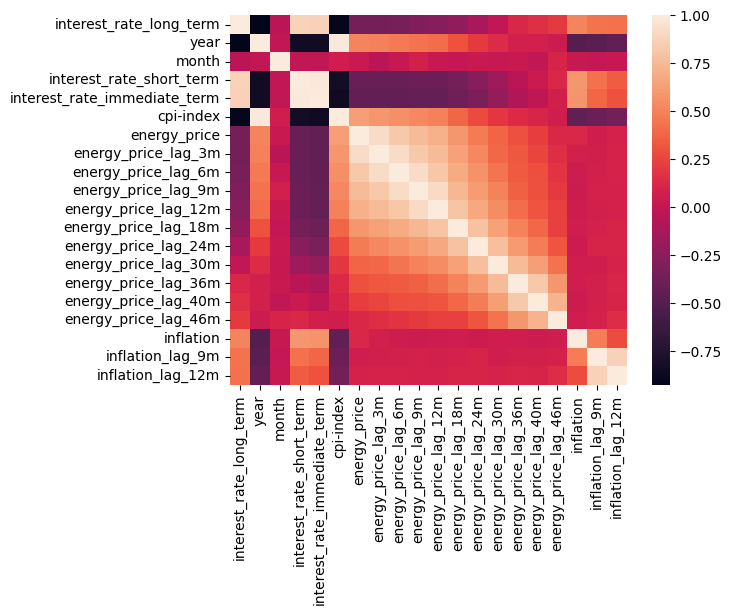

In [21]:
def correlation(df_country,country_name):
    print()
    print()
    print()
    print(f'===============================================================================')
    print(f'================================CORRELATION====================================')
    print(f'===============================================================================')
    print(f'================================COUNTRY [{country_name}]===================================')    
    print(f'===============================================================================')
    df_corr = df_country.corr(numeric_only=True,method=method, min_periods=min_periods)
    display(HTML(df_corr.to_html()))   
    sns.heatmap(df_corr)
    #sns.pairplot(df_country)
    plt.show()
    

correlation(df_au,'AUD')
correlation(df_us,'USA')
correlation(df_eu,'EU')

In [22]:
##################################__CHANGE OVER TIME__################################################

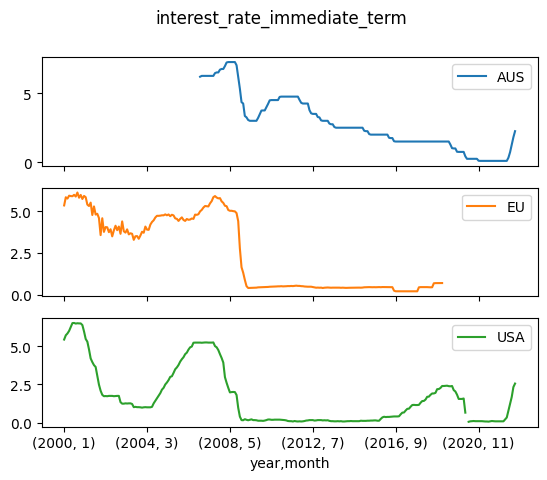

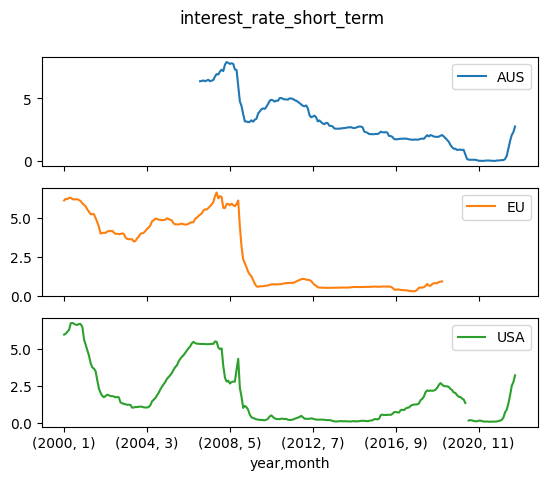

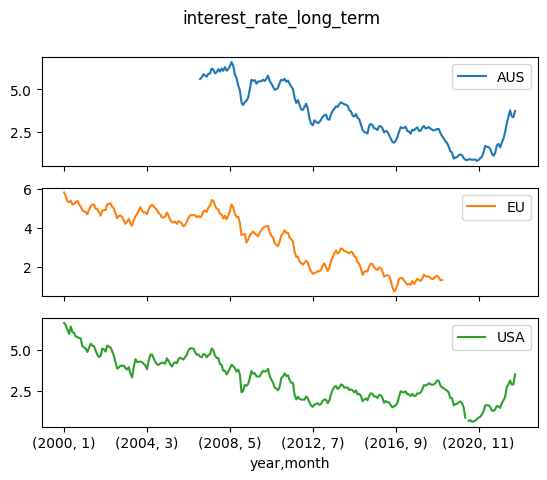

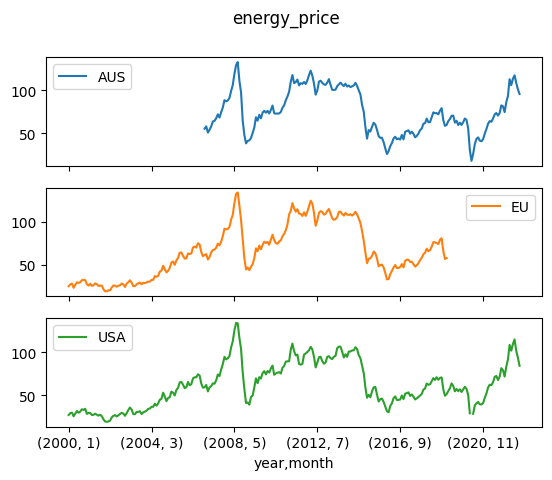

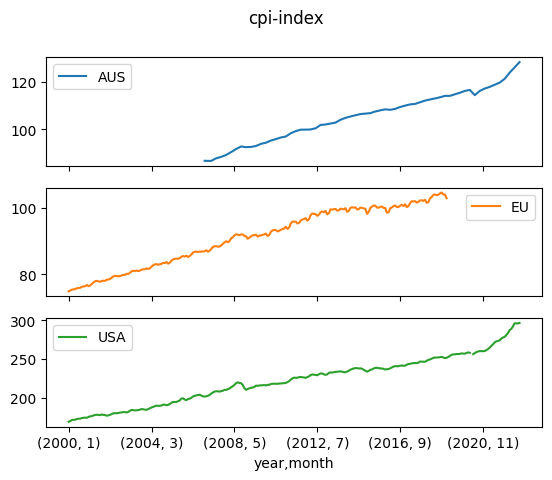

In [23]:
features = ['interest_rate_immediate_term','interest_rate_short_term','interest_rate_long_term','energy_price','cpi-index']

for index, feature in enumerate(features):
    tt = pd.pivot_table(df.reset_index(),
               index=['year','month'], columns='location', values=feature
              ).plot(subplots=True,title=feature)    

In [24]:
##################################__NORMAL DISTRIBUSION__################################################

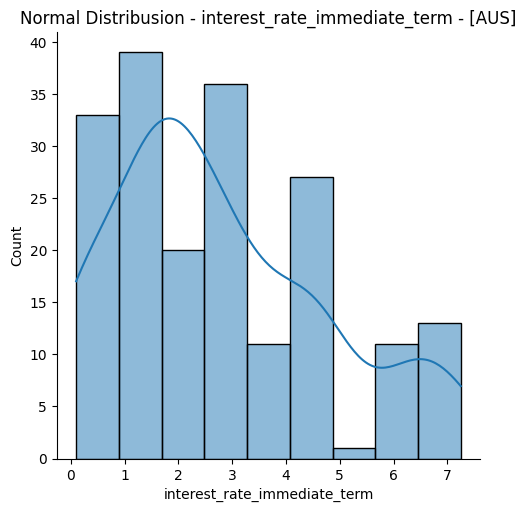

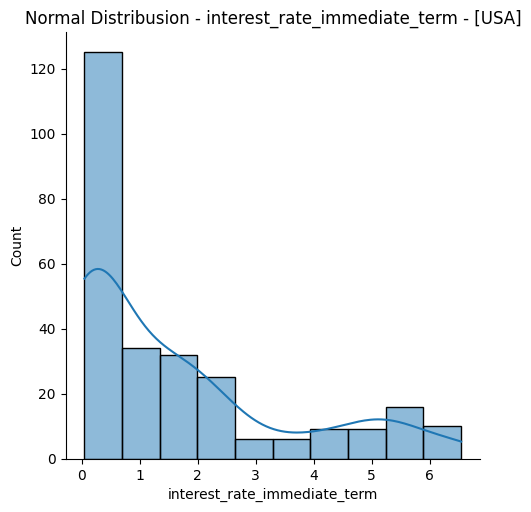

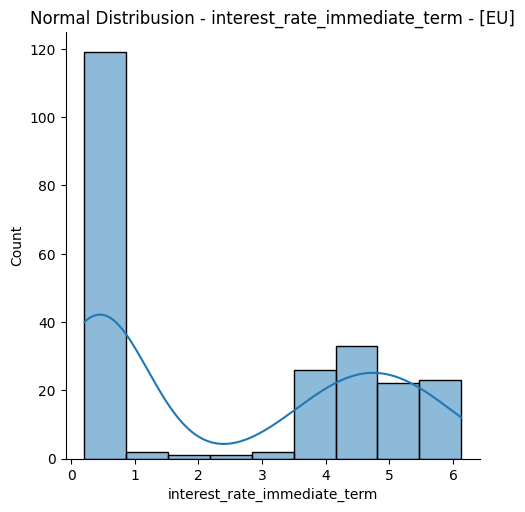

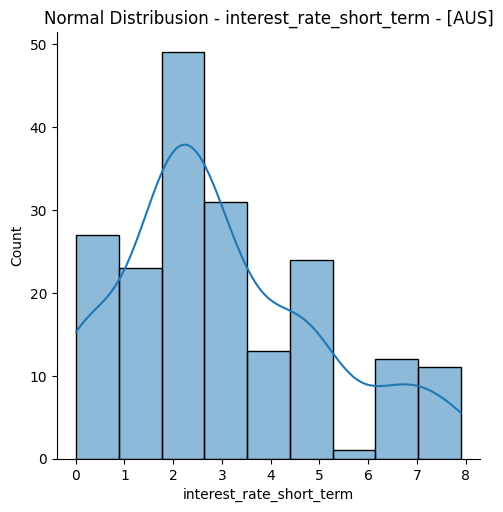

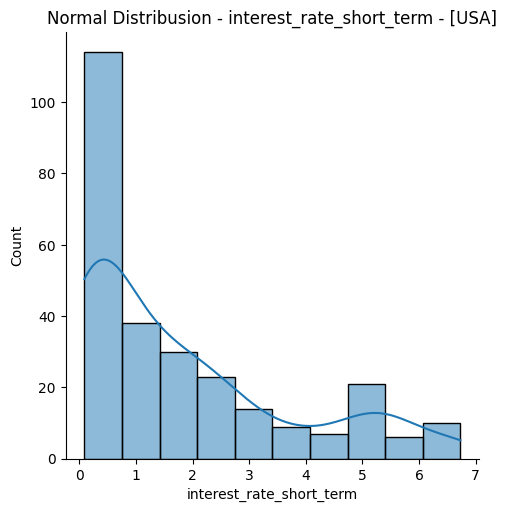

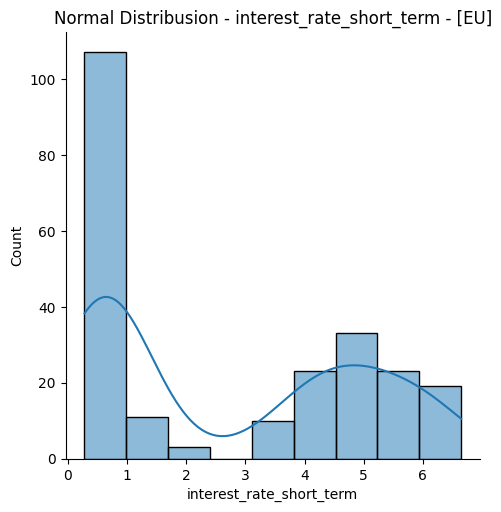

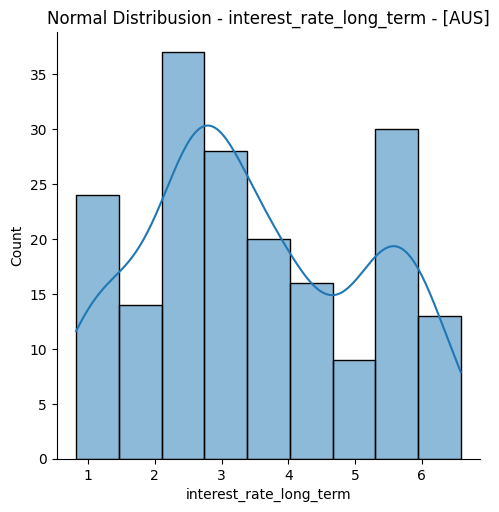

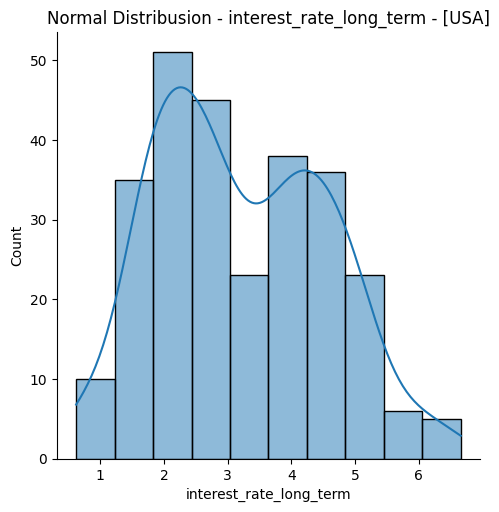

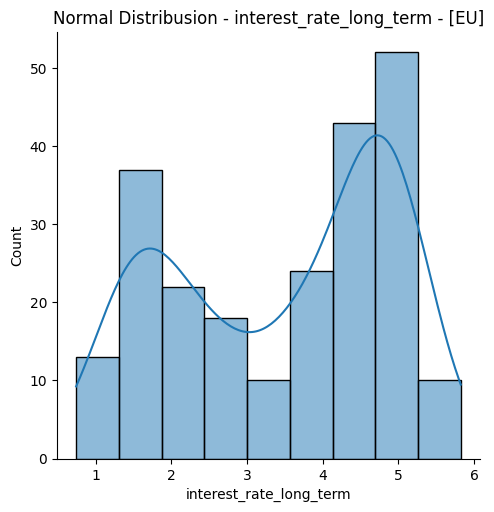

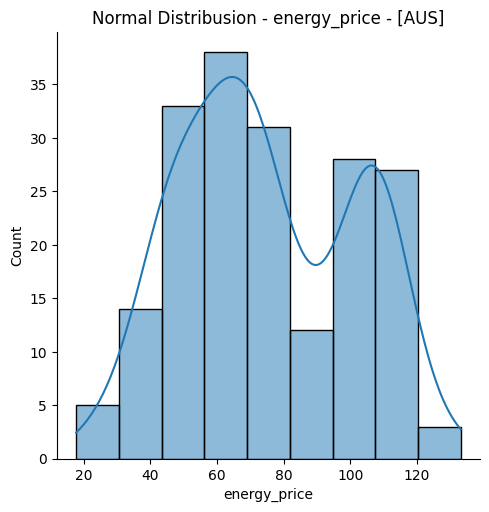

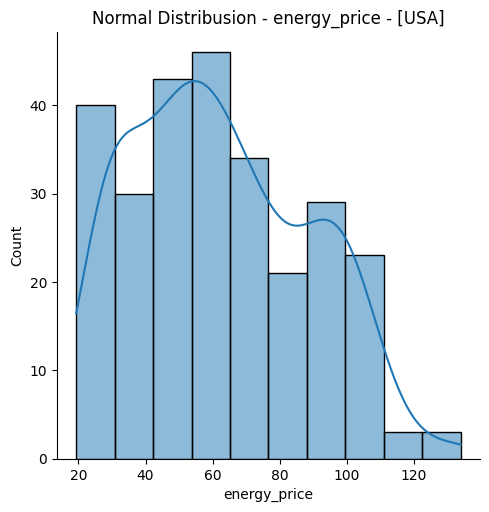

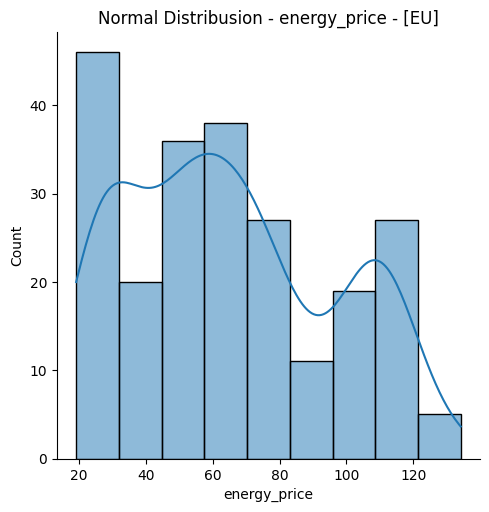

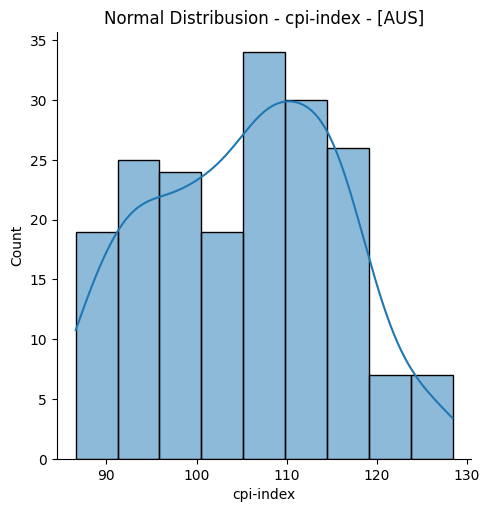

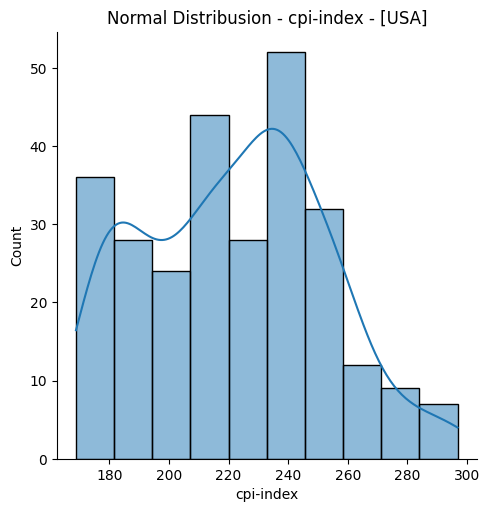

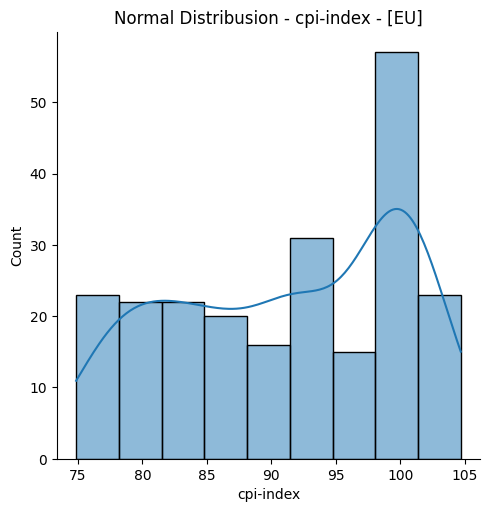

In [25]:
for index, feature in enumerate(features):
    sns.displot(df_au[feature], kde=True)
    plt.title(f'Normal Distribusion - {feature} - [AUS]')

    sns.displot(df_us[feature], kde=True)
    plt.title(f'Normal Distribusion - {feature} - [USA]')
    
    sns.displot(df_eu[feature], kde=True)
    plt.title(f'Normal Distribusion - {feature} - [EU]')